# HW6: Imitation Learning

> - Full Name: **Asemaneh Nafe**
> - Student ID: **400105285**
<!-- 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DeepRLCourse/Homework-5-Questions/blob/main/RL_HW11_Dyna.ipynb)
[![Open In kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/DeepRLCourse/Homework-11-Questions/main/RL_HW5_Dyna.ipynb) -->

## Overview
This assignment investigates the strengths and limitations of both reinforcement learning (PPO, A2C) and imitation learning (DAgger, GAIL) by applying them to control tasks. Students train and evaluate agents using expert demonstrations and environment feedback, gaining hands-on experience in designing and comparing learning algorithms across paradigms.


### **Exercise 1: Training PPO, A2C, and DAgger on CartPole-v1** (60 Points)

This exercise focuses on comparing reinforcement learning (PPO, A2C) and imitation learning (DAgger) techniques on the CartPole-v1 environment. An expert policy is first trained using PPO, then used to guide a DAgger agent. Separately, an A2C agent is trained directly via interaction with the environment. Performance metrics are collected to assess how each approach learns and generalizes.

---

### **Exercise 2: Training a GAIL Model Using an Expert Policy** (100 Points)

In this task, a GAIL (Generative Adversarial Imitation Learning) agent is trained to imitate a pre-trained expert policy in several environments (e.g., CartPole-v1, Pendulum-v0, BipedalWalker-v3). The training process involves configuring the environment, initializing models, and iteratively training the agent to match the expert’s behavior using adversarial learning.


In [2]:
import gymnasium as gym
from stable_baselines3 import PPO, DQN
from imitation.util.util import make_vec_env
from imitation.algorithms.dagger import SimpleDAggerTrainer
from imitation.algorithms import bc
from imitation.policies.serialize import load_policy
import os
import json
import pickle
import argparse
import torch
import tempfile
import numpy as np
from stable_baselines3 import PPO,DQN,A2C
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt

2025-07-31 12:29:26.180013: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753964966.508652      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753964966.602509      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Training PPO, A2C, and DAgger on the CartPole-v1 Environment

In this section, we explore and compare multiple reinforcement learning and imitation learning approaches within the classic **CartPole-v1** environment. The algorithms used include:

- **Proximal Policy Optimization (PPO)** – a stable, on-policy RL algorithm.
- **Advantage Actor-Critic (A2C)** – another on-policy RL algorithm known for simplicity and efficiency.
- **DAgger (Dataset Aggregation)** – an imitation learning algorithm that iteratively refines a policy using expert guidance.

---

## Main Objectives

1. **Train an expert policy using PPO**.
2. **Use the PPO expert to train a new agent via DAgger**.
3. **Train a separate agent using A2C directly**.
4. **Compare performance between PPO, DAgger, and A2C**.

This setup allows us to analyze the strengths of:
- **Reinforcement learning** (PPO and A2C) that learns from environment feedback.
- **Imitation learning** (DAgger) that learns from an expert’s demonstrations and corrections.

---

### 1. PPO Expert Training (15 Points)
- A PPO agent is trained in the CartPole-v1 environment using `stable-baselines3`.
- The model is saved and later reloaded as an expert policy for imitation learning.
- Training is done in intervals and evaluated periodically to track average rewards.

In [3]:
# Create the CartPole-v1 environment
env = gym.make("CartPole-v1")

model = PPO("MlpPolicy", env, verbose=1)
regular_rewards = []

# Training loop
total_timesteps = 10000
eval_freq = 1000 

for timestep in range(0, total_timesteps, eval_freq):
    model.learn(total_timesteps=eval_freq) 

    # TODO: Evaluate the model and record the reward
    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=5, render=False)
    regular_rewards.append(mean_reward)

    print(f"Regular Training - Step {timestep + eval_freq}: Mean Reward = {mean_reward}")

model.save("CartPole_v1_PPO_model.zip")
env.close()

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.6     |
|    ep_rew_mean     | 20.6     |
| time/              |          |
|    fps             | 606      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Regular Training - Step 1000: Mean Reward = 220.4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30.1     |
|    ep_rew_mean     | 30.1     |
| time/              |          |
|    fps             | 765      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
Regular Training - Step 2000: Mean Reward = 456.8
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48.6     |
|    ep_rew_mean     | 48.6     |
| time/              |          |
|    fps             | 770      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
Regular Training - Step 3000: Mean Reward = 500.0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 88       |
|    ep_rew_mean     | 88       |
| time/              |          |


### 2. DAgger Training with the PPO Expert (25 Points)
- A `BehaviorCloning` trainer is used to initialize the DAgger process.
- A `SimpleDAggerTrainer` collects data from both the expert and the learner during training.
- The model is updated incrementally and evaluated periodically.
- Performance rewards are stored to track learning progress.

In [6]:
# Load the PPO model manually using Stable-Baselines3's load method
expert = PPO.load("CartPole_v1_PPO_model.zip")

# Create a vectorized environment for imitation learning
rng = np.random.default_rng(0)
venv = make_vec_env("CartPole-v1", rng=rng)
# Initialize the Behavior Cloning (BC) trainer
bc_trainer = bc.BC(
    observation_space=venv.observation_space,
    action_space=venv.action_space,
    rng=rng,
)
# Record rewards during DAgger training
dagger_rewards = []

# Train using DAgger
with tempfile.TemporaryDirectory(prefix="dagger_example_") as tmpdir:
    dagger_trainer = SimpleDAggerTrainer(
        venv = venv,
        scratch_dir =tmpdir,
        expert_policy =expert,
        bc_trainer = bc_trainer,
        rng = rng,
    )    
    # Training loop for DAgger
    total_dagger_timesteps = 8000
    eval_freq = 1000
    for timestep in range(0, total_dagger_timesteps, eval_freq):
        dagger_trainer.train(eval_freq)

        # TODO: Evaluate the model and record the reward
        reward, _ = evaluate_policy(dagger_trainer.policy, venv, n_eval_episodes=5, render=False)
        dagger_rewards.append(reward)
        print(f"DAgger Training - Step {timestep + eval_freq}: Mean Reward = {reward}")

model.save("CartPole_v1_DAgger_model.zip")
venv.close()

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000693 |
|    entropy        | 0.693     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 72.5      |
|    loss           | 0.692     |
|    neglogp        | 0.693     |
|    prob_true_act  | 0.5       |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 35        |
|    return_mean    | 17.9      |
|    return_min     | 8         |
|    return_std     | 8.85      |
---------------------------------


108batch [00:00, 185.62batch/s]
238batch [00:01, 208.38batch/s]
367batch [00:01, 210.13batch/s]
495batch [00:02, 203.88batch/s]
500batch [00:02, 189.39batch/s]


DAgger Training - Step 1000: Mean Reward = 303.0


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000306 |
|    entropy        | 0.306     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 95.3      |
|    loss           | 0.222     |
|    neglogp        | 0.223     |
|    prob_true_act  | 0.828     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 334       |
|    return_mean    | 210       |
|    return_min     | 127       |
|    return_std     | 68.8      |
---------------------------------


235batch [00:01, 204.90batch/s]
496batch [00:02, 210.80batch/s]
Epoch 1 of 4                   

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -0.000335 |
|    entropy        | 0.335     |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 134       |
|    loss           | 0.284     |
|    neglogp        | 0.284     |
|    prob_true_act  | 0.789     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


735batch [00:04, 203.21batch/s]
997batch [00:05, 212.11batch/s]
1000batch [00:05, 168.48batch/s][A


DAgger Training - Step 2000: Mean Reward = 500.0


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000215 |
|    entropy        | 0.215     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 182       |
|    loss           | 0.103     |
|    neglogp        | 0.104     |
|    prob_true_act  | 0.91      |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


380batch [00:02, 204.88batch/s]
487batch [00:02, 208.08batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -0.000272 |
|    entropy        | 0.272     |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 212       |
|    loss           | 0.261     |
|    neglogp        | 0.261     |
|    prob_true_act  | 0.834     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


767batch [00:04, 207.91batch/s]
986batch [00:05, 209.97batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -0.000121 |
|    entropy        | 0.121     |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 231       |
|    loss           | 0.0926    |
|    neglogp        | 0.0927    |
|    prob_true_act  | 0.935     |
|    samples_so_far | 32032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


1157batch [00:07, 183.50batch/s]
1481batch [00:08, 210.04batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1500      |
|    ent_loss       | -0.000237 |
|    entropy        | 0.237     |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 249       |
|    loss           | 0.163     |
|    neglogp        | 0.163     |
|    prob_true_act  | 0.874     |
|    samples_so_far | 48032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


1541batch [00:09, 106.94batch/s]
1544batch [00:09, 157.40batch/s]


DAgger Training - Step 3000: Mean Reward = 500.0


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000161 |
|    entropy        | 0.161     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 251       |
|    loss           | 0.133     |
|    neglogp        | 0.133     |
|    prob_true_act  | 0.906     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


498batch [00:02, 210.16batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -0.000151 |
|    entropy        | 0.151     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 266       |
|    loss           | 0.0755    |
|    neglogp        | 0.0756    |
|    prob_true_act  | 0.936     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


520batch [00:03, 79.04batch/s] 
994batch [00:05, 207.34batch/s][A

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -0.000132 |
|    entropy        | 0.132     |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 281       |
|    loss           | 0.0796    |
|    neglogp        | 0.0797    |
|    prob_true_act  | 0.935     |
|    samples_so_far | 32032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


1036batch [00:06, 92.77batch/s]
1500batch [00:08, 207.35batch/s][A

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1500      |
|    ent_loss       | -8.81e-05 |
|    entropy        | 0.0881    |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 291       |
|    loss           | 0.0404    |
|    neglogp        | 0.0404    |
|    prob_true_act  | 0.965     |
|    samples_so_far | 48032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


1565batch [00:09, 114.23batch/s]
1983batch [00:11, 204.37batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 2000      |
|    ent_loss       | -7.28e-05 |
|    entropy        | 0.0728    |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 303       |
|    loss           | 0.0381    |
|    neglogp        | 0.0382    |
|    prob_true_act  | 0.968     |
|    samples_so_far | 64032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


2091batch [00:12, 149.13batch/s]
2092batch [00:12, 160.95batch/s]


DAgger Training - Step 4000: Mean Reward = 500.0


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000116 |
|    entropy        | 0.116     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 305       |
|    loss           | 0.0501    |
|    neglogp        | 0.0503    |
|    prob_true_act  | 0.956     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


486batch [00:02, 204.52batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -8.57e-05 |
|    entropy        | 0.0857    |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 315       |
|    loss           | 0.0287    |
|    neglogp        | 0.0288    |
|    prob_true_act  | 0.973     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 492       |
|    return_min     | 429       |
|    return_std     | 22.3      |
---------------------------------


629batch [00:04, 144.46batch/s]
987batch [00:06, 207.96batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -0.000102 |
|    entropy        | 0.102     |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 325       |
|    loss           | 0.0725    |
|    neglogp        | 0.0726    |
|    prob_true_act  | 0.946     |
|    samples_so_far | 32032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


1281batch [00:08, 202.52batch/s]
1491batch [00:09, 205.78batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1500      |
|    ent_loss       | -0.000133 |
|    entropy        | 0.133     |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 331       |
|    loss           | 0.146     |
|    neglogp        | 0.146     |
|    prob_true_act  | 0.912     |
|    samples_so_far | 48032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


1934batch [00:12, 209.40batch/s]
1998batch [00:12, 191.57batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 2000      |
|    ent_loss       | -1.73e-05 |
|    entropy        | 0.0173    |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 342       |
|    loss           | 0.00394   |
|    neglogp        | 0.00396   |
|    prob_true_act  | 0.996     |
|    samples_so_far | 64032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


2489batch [00:15, 208.70batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 2500      |
|    ent_loss       | -0.000109 |
|    entropy        | 0.109     |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 348       |
|    loss           | 0.0441    |
|    neglogp        | 0.0442    |
|    prob_true_act  | 0.96      |
|    samples_so_far | 80032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


2575batch [00:16, 132.02batch/s]
2592batch [00:16, 155.90batch/s]


DAgger Training - Step 5000: Mean Reward = 500.0


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | -6.8e-05 |
|    entropy        | 0.068    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 350      |
|    loss           | 0.0306   |
|    neglogp        | 0.0307   |
|    prob_true_act  | 0.974    |
|    samples_so_far | 32       |
| rollout/          |          |
|    return_max     | 500      |
|    return_mean    | 500      |
|    return_min     | 500      |
|    return_std     | 0        |
--------------------------------


491batch [00:02, 205.44batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -8.11e-05 |
|    entropy        | 0.0811    |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 358       |
|    loss           | 0.0369    |
|    neglogp        | 0.037     |
|    prob_true_act  | 0.968     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


765batch [00:04, 203.55batch/s]
980batch [00:05, 209.24batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -8.79e-05 |
|    entropy        | 0.0879    |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 364       |
|    loss           | 0.0405    |
|    neglogp        | 0.0406    |
|    prob_true_act  | 0.965     |
|    samples_so_far | 32032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


1497batch [00:08, 205.54batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1500      |
|    ent_loss       | -6.26e-05 |
|    entropy        | 0.0626    |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 370       |
|    loss           | 0.0316    |
|    neglogp        | 0.0317    |
|    prob_true_act  | 0.973     |
|    samples_so_far | 48032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


1539batch [00:09, 92.33batch/s] 
1981batch [00:11, 204.98batch/s][A

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 2000      |
|    ent_loss       | -0.000119 |
|    entropy        | 0.119     |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 376       |
|    loss           | 0.183     |
|    neglogp        | 0.183     |
|    prob_true_act  | 0.898     |
|    samples_so_far | 64032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 491       |
|    return_min     | 416       |
|    return_std     | 26.4      |
---------------------------------


2319batch [00:14, 203.76batch/s]
2491batch [00:15, 209.52batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 2500      |
|    ent_loss       | -0.000101 |
|    entropy        | 0.101     |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 383       |
|    loss           | 0.0617    |
|    neglogp        | 0.0618    |
|    prob_true_act  | 0.951     |
|    samples_so_far | 80032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


2987batch [00:18, 207.33batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 3000      |
|    ent_loss       | -0.000107 |
|    entropy        | 0.107     |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 389       |
|    loss           | 0.0524    |
|    neglogp        | 0.0525    |
|    prob_true_act  | 0.956     |
|    samples_so_far | 96032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


3071batch [00:19, 130.11batch/s]
3092batch [00:19, 158.59batch/s]


DAgger Training - Step 6000: Mean Reward = 500.0


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -9.97e-05 |
|    entropy        | 0.0997    |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 390       |
|    loss           | 0.074     |
|    neglogp        | 0.0741    |
|    prob_true_act  | 0.945     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


494batch [00:02, 201.57batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -9.18e-05 |
|    entropy        | 0.0918    |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 397       |
|    loss           | 0.0446    |
|    neglogp        | 0.0447    |
|    prob_true_act  | 0.962     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


878batch [00:05, 205.14batch/s]
983batch [00:05, 202.89batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -9.24e-05 |
|    entropy        | 0.0924    |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 404       |
|    loss           | 0.0415    |
|    neglogp        | 0.0416    |
|    prob_true_act  | 0.963     |
|    samples_so_far | 32032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


1481batch [00:08, 210.85batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1500      |
|    ent_loss       | -5.49e-05 |
|    entropy        | 0.0549    |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 411       |
|    loss           | 0.0331    |
|    neglogp        | 0.0331    |
|    prob_true_act  | 0.973     |
|    samples_so_far | 48032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 487       |
|    return_min     | 387       |
|    return_std     | 35.5      |
---------------------------------


1794batch [00:11, 202.83batch/s]
1984batch [00:12, 207.62batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 2000      |
|    ent_loss       | -8.38e-05 |
|    entropy        | 0.0838    |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 414       |
|    loss           | 0.122     |
|    neglogp        | 0.122     |
|    prob_true_act  | 0.93      |
|    samples_so_far | 64032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


2496batch [00:15, 209.70batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 2500      |
|    ent_loss       | -9.55e-05 |
|    entropy        | 0.0955    |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 421       |
|    loss           | 0.0509    |
|    neglogp        | 0.051     |
|    prob_true_act  | 0.957     |
|    samples_so_far | 80032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


2691batch [00:16, 193.69batch/s]
2999batch [00:18, 212.64batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 3000      |
|    ent_loss       | -8.09e-05 |
|    entropy        | 0.0809    |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 426       |
|    loss           | 0.0371    |
|    neglogp        | 0.0372    |
|    prob_true_act  | 0.968     |
|    samples_so_far | 96032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


3493batch [00:21, 208.54batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 3500      |
|    ent_loss       | -1.36e-05 |
|    entropy        | 0.0136    |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 431       |
|    loss           | 0.00353   |
|    neglogp        | 0.00355   |
|    prob_true_act  | 0.997     |
|    samples_so_far | 112032    |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


3580batch [00:22, 134.34batch/s]
3592batch [00:22, 160.12batch/s]


DAgger Training - Step 7000: Mean Reward = 500.0


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -8.94e-05 |
|    entropy        | 0.0894    |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 432       |
|    loss           | 0.158     |
|    neglogp        | 0.158     |
|    prob_true_act  | 0.912     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


480batch [00:02, 212.39batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -3.53e-05 |
|    entropy        | 0.0353    |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 436       |
|    loss           | 0.038     |
|    neglogp        | 0.0381    |
|    prob_true_act  | 0.975     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


998batch [00:05, 207.28batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | -5.6e-05 |
|    entropy        | 0.056    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 442      |
|    loss           | 0.0224   |
|    neglogp        | 0.0224   |
|    prob_true_act  | 0.98     |
|    samples_so_far | 32032    |
| rollout/          |          |
|    return_max     | 500      |
|    return_mean    | 500      |
|    return_min     | 500      |
|    return_std     | 0        |
--------------------------------


1019batch [00:06, 78.25batch/s]
1492batch [00:08, 204.08batch/s][A

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1500     |
|    ent_loss       | -8.5e-05 |
|    entropy        | 0.085    |
|    epoch          | 1        |
|    l2_loss        | 0        |
|    l2_norm        | 445      |
|    loss           | 0.0387   |
|    neglogp        | 0.0388   |
|    prob_true_act  | 0.966    |
|    samples_so_far | 48032    |
| rollout/          |          |
|    return_max     | 500      |
|    return_mean    | 500      |
|    return_min     | 500      |
|    return_std     | 0        |
--------------------------------


1986batch [00:11, 211.19batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 2000     |
|    ent_loss       | -2.1e-05 |
|    entropy        | 0.021    |
|    epoch          | 1        |
|    l2_loss        | 0        |
|    l2_norm        | 450      |
|    loss           | 0.00595  |
|    neglogp        | 0.00597  |
|    prob_true_act  | 0.994    |
|    samples_so_far | 64032    |
| rollout/          |          |
|    return_max     | 500      |
|    return_mean    | 500      |
|    return_min     | 500      |
|    return_std     | 0        |
--------------------------------


2029batch [00:12, 95.64batch/s] 
2492batch [00:14, 206.94batch/s][A

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 2500      |
|    ent_loss       | -4.47e-05 |
|    entropy        | 0.0447    |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 455       |
|    loss           | 0.0213    |
|    neglogp        | 0.0214    |
|    prob_true_act  | 0.982     |
|    samples_so_far | 80032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


2982batch [00:17, 209.82batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 3000      |
|    ent_loss       | -6.02e-05 |
|    entropy        | 0.0602    |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 458       |
|    loss           | 0.202     |
|    neglogp        | 0.202     |
|    prob_true_act  | 0.928     |
|    samples_so_far | 96032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


3066batch [00:18, 129.13batch/s]
3488batch [00:20, 207.98batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 3500      |
|    ent_loss       | -1.25e-05 |
|    entropy        | 0.0125    |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 462       |
|    loss           | 0.00277   |
|    neglogp        | 0.00278   |
|    prob_true_act  | 0.997     |
|    samples_so_far | 112032    |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


3996batch [00:23, 208.80batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 4000      |
|    ent_loss       | -3.68e-05 |
|    entropy        | 0.0368    |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 466       |
|    loss           | 0.0159    |
|    neglogp        | 0.0159    |
|    prob_true_act  | 0.986     |
|    samples_so_far | 128032    |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


4080batch [00:24, 130.59batch/s]
4092batch [00:25, 163.54batch/s]


DAgger Training - Step 8000: Mean Reward = 500.0


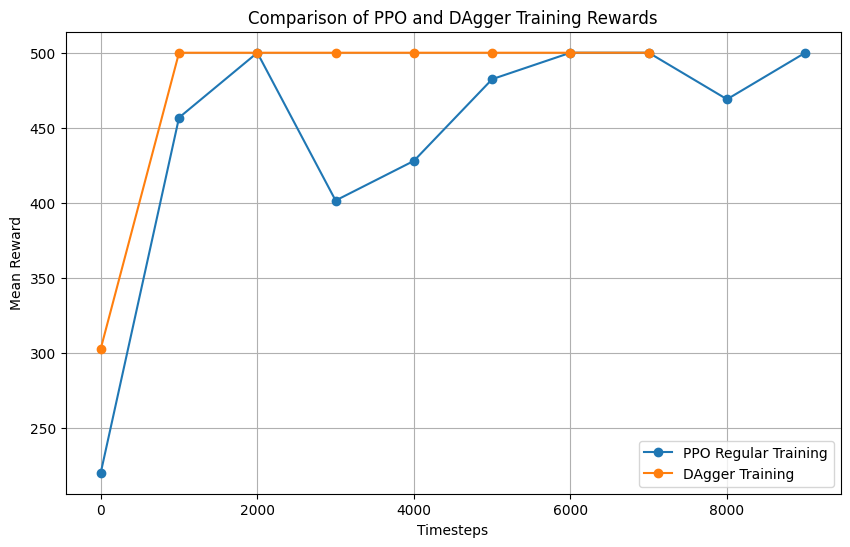

In [7]:
# Plot the rewards for Regular PPO Training and DAgger Training
plt.figure(figsize=(10, 6))
plt.plot(range(0, 10000, 1000), regular_rewards, label="PPO Regular Training", marker="o")
plt.plot(range(0, 8000, 1000), dagger_rewards, label="DAgger Training", marker="o")
plt.xlabel("Timesteps")
plt.ylabel("Mean Reward")
plt.title("Comparison of PPO and DAgger Training Rewards")
plt.legend()
plt.grid(True)
plt.show()


### 3. A2C Agent Training (20 Points)
After DAgger training, a third agent is trained using the **Advantage Actor-Critic (A2C)** algorithm.

In [8]:

# Create the CartPole-v1 environment
env = gym.make("CartPole-v1")

# Initialize the A2C model
model = A2C("MlpPolicy", env, verbose=1)
# Record rewards during training
regular_rewards = []

# Training loop
total_timesteps = 10000
eval_freq = 1000 
for timestep in range(0, total_timesteps, eval_freq):
    model.learn(total_timesteps=eval_freq) 

    # TODO: Evaluate the model and record the reward
    reward, _ = evaluate_policy(model, env, n_eval_episodes=5, render=False)
    regular_rewards.append(reward)
    print(f"Regular Training - Step {timestep + eval_freq}: Mean Reward = {reward}")

# Save the model after training
model.save("CartPole_v1_DQN_model.zip")
env.close()

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 37.5     |
|    ep_rew_mean        | 37.5     |
| time/                 |          |
|    fps                | 459      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.579   |
|    explained_variance | 0.249    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 1.69     |
|    value_loss         | 10.2     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 45.7     |
|    ep_rew_mean        | 45.7     |
| time/                 |          |
|    fps                | 452      |
|    iterations         | 200      |
|    time_elapsed

In [10]:
# Load the A2C model manually using Stable-Baselines3's load method
expert = A2C.load("CartPole_v1_DQN_model.zip")
rng = np.random.default_rng(0)
venv = make_vec_env("CartPole-v1", rng=rng)
# Initialize the Behavior Cloning (BC) trainer
bc_trainer = bc.BC(
    observation_space = venv.observation_space,
    action_space = venv.action_space,
    rng = rng,
)# Record rewards during DAgger training
dagger_rewards = []

# Train using DAgger
with tempfile.TemporaryDirectory(prefix="dagger_example_") as tmpdir:
    dagger_trainer = SimpleDAggerTrainer(
        venv = venv,
        scratch_dir =tmpdir,
        expert_policy =expert,
        bc_trainer = bc_trainer,
        rng = rng,
    )
    
    # Training loop for DAgger
    total_dagger_timesteps = 8000
    eval_freq = 1000 
    for timestep in range(0, total_dagger_timesteps, eval_freq):
        dagger_trainer.train(eval_freq)  # Train the agent for `eval_freq` timesteps

        # TODO: Evaluate the model and record the reward
        reward, _ = evaluate_policy(dagger_trainer.policy, venv, n_eval_episodes=5, render=False)
        dagger_rewards.append(reward)
        print(f"DAgger Training - Step {timestep + eval_freq}: Mean Reward = {reward}")

# Close the environment after DAgger training
venv.close()

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000693 |
|    entropy        | 0.693     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 72.5      |
|    loss           | 0.693     |
|    neglogp        | 0.694     |
|    prob_true_act  | 0.499     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 30        |
|    return_mean    | 19.7      |
|    return_min     | 12        |
|    return_std     | 5.79      |
---------------------------------


70batch [00:00, 187.46batch/s]
154batch [00:00, 202.67batch/s][A
238batch [00:01, 204.24batch/s]
324batch [00:01, 208.05batch/s]
336batch [00:01, 197.66batch/s]


DAgger Training - Step 1000: Mean Reward = 220.6


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000116 |
|    entropy        | 0.116     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 103       |
|    loss           | 0.0585    |
|    neglogp        | 0.0586    |
|    prob_true_act  | 0.951     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 276       |
|    return_mean    | 233       |
|    return_min     | 176       |
|    return_std     | 30.8      |
---------------------------------


170batch [00:01, 188.85batch/s]
339batch [00:02, 206.04batch/s]
490batch [00:02, 210.06batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | -4.9e-05 |
|    entropy        | 0.049    |
|    epoch          | 2        |
|    l2_loss        | 0        |
|    l2_norm        | 126      |
|    loss           | 0.0186   |
|    neglogp        | 0.0186   |
|    prob_true_act  | 0.983    |
|    samples_so_far | 16032    |
| rollout/          |          |
|    return_max     | 387      |
|    return_mean    | 211      |
|    return_min     | 147      |
|    return_std     | 59.8     |
--------------------------------


512batch [00:03, 86.82batch/s] 
681batch [00:04, 193.14batch/s][A
684batch [00:04, 156.29batch/s]


DAgger Training - Step 2000: Mean Reward = 234.6


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -3.18e-05 |
|    entropy        | 0.0318    |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 132       |
|    loss           | 0.013     |
|    neglogp        | 0.013     |
|    prob_true_act  | 0.989     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 330       |
|    return_mean    | 242       |
|    return_min     | 189       |
|    return_std     | 47.1      |
---------------------------------


233batch [00:01, 199.79batch/s]
463batch [00:02, 197.83batch/s]
483batch [00:02, 197.14batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -5.87e-05 |
|    entropy        | 0.0587    |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 146       |
|    loss           | 0.0236    |
|    neglogp        | 0.0236    |
|    prob_true_act  | 0.979     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 322       |
|    return_mean    | 226       |
|    return_min     | 182       |
|    return_std     | 39.7      |
---------------------------------


690batch [00:04, 193.55batch/s]
923batch [00:05, 202.11batch/s]
940batch [00:05, 162.75batch/s]


DAgger Training - Step 3000: Mean Reward = 253.4


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -7.11e-05 |
|    entropy        | 0.0711    |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 156       |
|    loss           | 0.0286    |
|    neglogp        | 0.0287    |
|    prob_true_act  | 0.974     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 320       |
|    return_mean    | 235       |
|    return_min     | 189       |
|    return_std     | 40.7      |
---------------------------------


315batch [00:02, 202.48batch/s]
483batch [00:02, 205.24batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -3.22e-05 |
|    entropy        | 0.0322    |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 165       |
|    loss           | 0.025     |
|    neglogp        | 0.0251    |
|    prob_true_act  | 0.982     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 361       |
|    return_mean    | 248       |
|    return_min     | 185       |
|    return_std     | 49.6      |
---------------------------------


630batch [00:04, 168.37batch/s]
947batch [00:05, 206.77batch/s]
989batch [00:05, 203.35batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | -1.1e-05 |
|    entropy        | 0.011    |
|    epoch          | 3        |
|    l2_loss        | 0        |
|    l2_norm        | 174      |
|    loss           | 0.00228  |
|    neglogp        | 0.00229  |
|    prob_true_act  | 0.998    |
|    samples_so_far | 32032    |
| rollout/          |          |
|    return_max     | 315      |
|    return_mean    | 226      |
|    return_min     | 180      |
|    return_std     | 37.8     |
--------------------------------


1260batch [00:07, 198.63batch/s]
1264batch [00:07, 158.23batch/s]


DAgger Training - Step 4000: Mean Reward = 203.6


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -1.69e-05 |
|    entropy        | 0.0169    |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 178       |
|    loss           | 0.00427   |
|    neglogp        | 0.00429   |
|    prob_true_act  | 0.996     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 339       |
|    return_mean    | 220       |
|    return_min     | 170       |
|    return_std     | 42.4      |
---------------------------------


399batch [00:02, 205.53batch/s]
483batch [00:02, 203.90batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -4.89e-05 |
|    entropy        | 0.0489    |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 186       |
|    loss           | 0.0307    |
|    neglogp        | 0.0307    |
|    prob_true_act  | 0.975     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 432       |
|    return_mean    | 266       |
|    return_min     | 183       |
|    return_std     | 67.5      |
---------------------------------


827batch [00:05, 208.16batch/s]
995batch [00:05, 205.25batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -4.23e-05 |
|    entropy        | 0.0423    |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 192       |
|    loss           | 0.0238    |
|    neglogp        | 0.0239    |
|    prob_true_act  | 0.981     |
|    samples_so_far | 32032     |
| rollout/          |           |
|    return_max     | 344       |
|    return_mean    | 242       |
|    return_min     | 164       |
|    return_std     | 64        |
---------------------------------


1239batch [00:07, 191.06batch/s]
1492batch [00:09, 208.52batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1500      |
|    ent_loss       | -1.47e-06 |
|    entropy        | 0.00147   |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 197       |
|    loss           | 0.000253  |
|    neglogp        | 0.000255  |
|    prob_true_act  | 1         |
|    samples_so_far | 48032     |
| rollout/          |           |
|    return_max     | 314       |
|    return_mean    | 214       |
|    return_min     | 169       |
|    return_std     | 35.6      |
---------------------------------


1660batch [00:10, 178.42batch/s]
1672batch [00:10, 157.91batch/s]


DAgger Training - Step 5000: Mean Reward = 238.4


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -2.38e-07 |
|    entropy        | 0.000238  |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 198       |
|    loss           | 2.79e-05  |
|    neglogp        | 2.82e-05  |
|    prob_true_act  | 1         |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 300       |
|    return_mean    | 245       |
|    return_min     | 193       |
|    return_std     | 39.6      |
---------------------------------


486batch [00:02, 203.44batch/s]
Epoch 0 of 4                   

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | -1.8e-06 |
|    entropy        | 0.0018   |
|    epoch          | 1        |
|    l2_loss        | 0        |
|    l2_norm        | 202      |
|    loss           | 0.000305 |
|    neglogp        | 0.000307 |
|    prob_true_act  | 1        |
|    samples_so_far | 16032    |
| rollout/          |          |
|    return_max     | 303      |
|    return_mean    | 233      |
|    return_min     | 184      |
|    return_std     | 35.5     |
--------------------------------


970batch [00:05, 203.82batch/s]
991batch [00:06, 201.51batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -1.73e-05 |
|    entropy        | 0.0173    |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 206       |
|    loss           | 0.00848   |
|    neglogp        | 0.00849   |
|    prob_true_act  | 0.993     |
|    samples_so_far | 32032     |
| rollout/          |           |
|    return_max     | 347       |
|    return_mean    | 234       |
|    return_min     | 186       |
|    return_std     | 45.2      |
---------------------------------


1478batch [00:08, 206.77batch/s]
1499batch [00:09, 204.74batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1500      |
|    ent_loss       | -2.25e-05 |
|    entropy        | 0.0225    |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 209       |
|    loss           | 0.00757   |
|    neglogp        | 0.00759   |
|    prob_true_act  | 0.993     |
|    samples_so_far | 48032     |
| rollout/          |           |
|    return_max     | 403       |
|    return_mean    | 240       |
|    return_min     | 176       |
|    return_std     | 60.8      |
---------------------------------


1961batch [00:11, 204.99batch/s]
1980batch [00:12, 164.84batch/s]


DAgger Training - Step 6000: Mean Reward = 239.6


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -1.31e-05 |
|    entropy        | 0.0131    |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 211       |
|    loss           | 0.00327   |
|    neglogp        | 0.00328   |
|    prob_true_act  | 0.997     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 303       |
|    return_mean    | 237       |
|    return_min     | 171       |
|    return_std     | 40        |
---------------------------------


486batch [00:02, 205.67batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -1.03e-05 |
|    entropy        | 0.0103    |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 214       |
|    loss           | 0.00333   |
|    neglogp        | 0.00334   |
|    prob_true_act  | 0.997     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 337       |
|    return_mean    | 238       |
|    return_min     | 184       |
|    return_std     | 48.1      |
---------------------------------


570batch [00:04, 125.59batch/s]
996batch [00:06, 206.62batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | -2e-05   |
|    entropy        | 0.02     |
|    epoch          | 1        |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 0.0119   |
|    neglogp        | 0.012    |
|    prob_true_act  | 0.99     |
|    samples_so_far | 32032    |
| rollout/          |          |
|    return_max     | 338      |
|    return_mean    | 245      |
|    return_min     | 199      |
|    return_std     | 42.7     |
--------------------------------


1145batch [00:07, 170.67batch/s]
1483batch [00:09, 203.53batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1500      |
|    ent_loss       | -3.06e-06 |
|    entropy        | 0.00306   |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 220       |
|    loss           | 0.000528  |
|    neglogp        | 0.000531  |
|    prob_true_act  | 0.999     |
|    samples_so_far | 48032     |
| rollout/          |           |
|    return_max     | 308       |
|    return_mean    | 222       |
|    return_min     | 175       |
|    return_std     | 43.1      |
---------------------------------


1734batch [00:10, 197.67batch/s]
1994batch [00:12, 207.95batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 2000      |
|    ent_loss       | -1.16e-05 |
|    entropy        | 0.0116    |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 223       |
|    loss           | 0.00283   |
|    neglogp        | 0.00284   |
|    prob_true_act  | 0.997     |
|    samples_so_far | 64032     |
| rollout/          |           |
|    return_max     | 314       |
|    return_mean    | 245       |
|    return_min     | 188       |
|    return_std     | 43.1      |
---------------------------------


2309batch [00:14, 200.79batch/s]
2312batch [00:14, 161.62batch/s]


DAgger Training - Step 7000: Mean Reward = 277.4


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | -4.3e-05 |
|    entropy        | 0.043    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 224      |
|    loss           | 0.0467   |
|    neglogp        | 0.0467   |
|    prob_true_act  | 0.967    |
|    samples_so_far | 32       |
| rollout/          |          |
|    return_max     | 285      |
|    return_mean    | 230      |
|    return_min     | 172      |
|    return_std     | 36.5     |
--------------------------------


487batch [00:02, 209.28batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -7.18e-08 |
|    entropy        | 7.18e-05  |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 225       |
|    loss           | 7.23e-06  |
|    neglogp        | 7.3e-06   |
|    prob_true_act  | 1         |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 299       |
|    return_mean    | 235       |
|    return_min     | 186       |
|    return_std     | 34.8      |
---------------------------------


671batch [00:04, 179.61batch/s]
985batch [00:06, 200.14batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -6.02e-09 |
|    entropy        | 6.02e-06  |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 227       |
|    loss           | 4.71e-07  |
|    neglogp        | 4.77e-07  |
|    prob_true_act  | 1         |
|    samples_so_far | 32032     |
| rollout/          |           |
|    return_max     | 276       |
|    return_mean    | 223       |
|    return_min     | 185       |
|    return_std     | 29.9      |
---------------------------------


1346batch [00:08, 207.72batch/s]
1493batch [00:09, 205.75batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1500      |
|    ent_loss       | -5.32e-05 |
|    entropy        | 0.0532    |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 227       |
|    loss           | 0.0244    |
|    neglogp        | 0.0244    |
|    prob_true_act  | 0.979     |
|    samples_so_far | 48032     |
| rollout/          |           |
|    return_max     | 313       |
|    return_mean    | 233       |
|    return_min     | 173       |
|    return_std     | 47        |
---------------------------------


1986batch [00:11, 203.00batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 2000      |
|    ent_loss       | -2.61e-07 |
|    entropy        | 0.000261  |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 229       |
|    loss           | 3.3e-05   |
|    neglogp        | 3.33e-05  |
|    prob_true_act  | 1         |
|    samples_so_far | 64032     |
| rollout/          |           |
|    return_max     | 309       |
|    return_mean    | 243       |
|    return_min     | 172       |
|    return_std     | 48        |
---------------------------------


2007batch [00:12, 74.90batch/s] 
2499batch [00:15, 208.25batch/s][A

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 2500      |
|    ent_loss       | -7.25e-06 |
|    entropy        | 0.00725   |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 228       |
|    loss           | 0.00199   |
|    neglogp        | 0.00199   |
|    prob_true_act  | 0.998     |
|    samples_so_far | 80032     |
| rollout/          |           |
|    return_max     | 316       |
|    return_mean    | 259       |
|    return_min     | 202       |
|    return_std     | 36.5      |
---------------------------------


2687batch [00:16, 184.98batch/s]
2692batch [00:16, 161.80batch/s]


DAgger Training - Step 8000: Mean Reward = 231.0


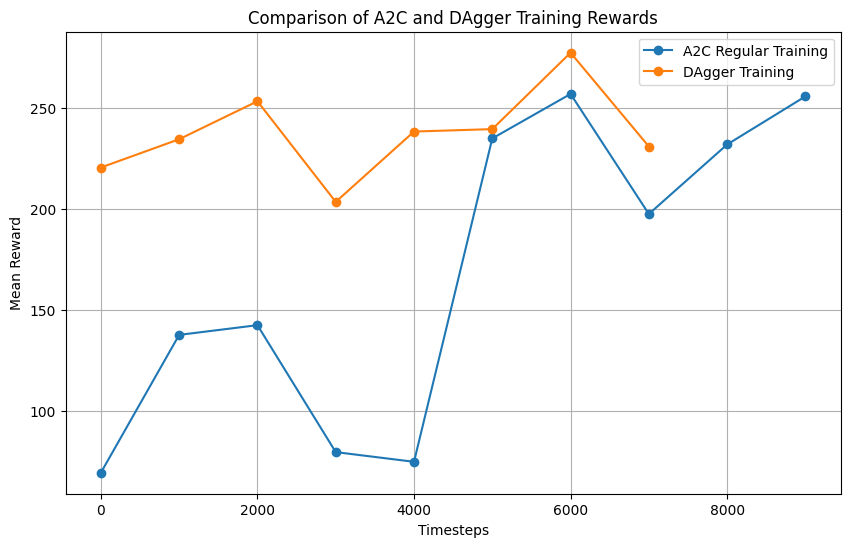

In [11]:
# Plot the rewards for Regular A2C Training and DAgger Training
plt.figure(figsize=(10, 6))
plt.plot(range(0, 10000, 1000), regular_rewards, label="A2C Regular Training", marker="o")
plt.plot(range(0, 8000, 1000), dagger_rewards, label="DAgger Training", marker="o")

plt.xlabel("Timesteps")
plt.ylabel("Mean Reward")
plt.title("Comparison of A2C and DAgger Training Rewards")
plt.legend()

plt.grid(True)
plt.show()

# Training a GAIL Model Using an Expert Policy

In this section, we walk through the process of setting up and training a **Generative Adversarial Imitation Learning (GAIL)** model using a pre-trained expert in environments such as `CartPole-v1`, `Pendulum-v0`, and `BipedalWalker-v3`.

The full pipeline includes:
- Setting up directories and configurations,
- Loading and validating the environment,
- Initializing expert and GAIL models,
- Training GAIL using the expert’s behavior,
- Saving the final results and model weights.

## Summary

This pipeline implements a complete imitation learning workflow using GAIL. The process involves:
- Setting up a Gym-compatible environment,
- Loading a pre-trained expert model,
- Training a GAIL agent to mimic the expert,
- Storing the training results and model artifacts.

By following this structure, we can compare GAIL's performance to reinforcement learning approaches like PPO or A2C, and evaluate the efficiency of learning from demonstrations.

---


In [ ]:
import os
import json
import requests
import gym
import argparse
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [24]:
import urllib.request

# Define the files and their URLs
files_to_download = {
    "gail_code/models/nets.py": "https://raw.githubusercontent.com/hcnoh/gail-pytorch/main/models/nets.py",
    "gail_code/models/gail.py": "https://raw.githubusercontent.com/hcnoh/gail-pytorch/main/models/gail.py",
    "gail_code/utils/funcs.py": "https://raw.githubusercontent.com/hcnoh/gail-pytorch/main/utils/funcs.py",
}

# Create directories if they don't exist
os.makedirs("gail_code/models", exist_ok=True)
os.makedirs("gail_code/utils", exist_ok=True)

# Download files
for dest, url in files_to_download.items():
    urllib.request.urlretrieve(url, dest)
    print(f"Downloaded {dest}")


Downloaded gail_code/models/nets.py
Downloaded gail_code/models/gail.py
Downloaded gail_code/utils/funcs.py


In [29]:
import sys
sys.path.append("gail_code")

from models.nets import *
from models.gail import *
from utils.funcs import *

### **1. `setup_directories(env_name)`** (5 Points)

```python
This function handles directory setup and expert configuration:
- Creates a base checkpoint directory (`ckpts/`).
- Validates if the provided environment name is supported.
- Loads the expert model configuration from a JSON file.
- Creates a subdirectory for storing environment-specific checkpoints.

**Purpose:** Prepare the file system and load settings for the expert model.

In [32]:

def setup_directories(env_name):
    # Create base checkpoint directory if it doesn't exist
    ckpt_path = "ckpts"
    os.makedirs(ckpt_path, exist_ok=True)

    # Validate the environment name
    if env_name not in ["CartPole-v1", "Pendulum-v0", "BipedalWalker-v3"]:
        print("The environment name is wrong!")
        return None

    # Define base URLs for config and weights
    base_url = "https://raw.githubusercontent.com/hcnoh/gail-pytorch/main/experts"
    config_url = f"{base_url}/{env_name}/model_config.json"
    policy_url = f"{base_url}/{env_name}/policy.ckpt"

    # Download model_config.json
    try:
        response = requests.get(config_url)
        response.raise_for_status()
        expert_config = response.json()
    except Exception as e:
        print(f"Failed to fetch expert config from GitHub: {e}")
        return None

    # Prepare local expert directory
    expert_ckpt_path = os.path.join("experts", env_name)
    os.makedirs(expert_ckpt_path, exist_ok=True)

    # Save model_config.json locally
    config_path = os.path.join(expert_ckpt_path, "model_config.json")
    with open(config_path, "w") as f:
        json.dump(expert_config, f, indent=2)

    # Download policy.ckpt
    policy_path = os.path.join(expert_ckpt_path, "policy.ckpt")
    try:
        policy_response = requests.get(policy_url)
        policy_response.raise_for_status()
        with open(policy_path, "wb") as f:
            f.write(policy_response.content)
    except Exception as e:
        print(f"Failed to download policy.ckpt: {e}")
        return None

    # Create environment-specific checkpoint directory
    ckpt_path = os.path.join(ckpt_path, env_name)
    os.makedirs(ckpt_path, exist_ok=True)

    return expert_ckpt_path, expert_config, ckpt_path


In [6]:


def load_and_save_configs(expert_ckpt_path, ckpt_path, env_name):
    # URL of the global config.json file (raw version from GitHub)
    config_url = "https://raw.githubusercontent.com/hcnoh/gail-pytorch/main/config.json"

    try:
        response = requests.get(config_url)
        response.raise_for_status()
        all_configs = response.json()
    except Exception as e:
        print(f"Failed to load config.json from GitHub: {e}")
        return None

    # Extract config specific to the environment
    if env_name not in all_configs:
        print(f"No config found for environment: {env_name}")
        return None

    config = all_configs[env_name]

    # Save config to the checkpoint directory for reproducibility
    os.makedirs(ckpt_path, exist_ok=True)
    save_path = os.path.join(ckpt_path, "config.json")
    with open(save_path, "w") as f:
        json.dump(config, f, indent=2)

    print(f"Saved config for {env_name} at {save_path}")
    return config

### **2. `load_and_save_configs(expert_ckpt_path, ckpt_path, env_name)`** (10 Points)
- Loads a general configuration file (`config.json`) that contains training hyperparameters specific to the environment.
- Saves these configurations to the current checkpoint folder for logging and reproducibility.

**Purpose:** Fetch and store hyperparameters needed for training the GAIL model.

In [33]:
expert_ckpt_path, expert_config, ckpt_path = setup_directories("CartPole-v1")
config = load_and_save_configs(expert_ckpt_path, ckpt_path, "CartPole-v1")

Saved config for CartPole-v1 at ckpts/CartPole-v1/config.json


### **3. `setup_environment(env_name)`** (10 Points)

- Initializes the chosen environment using OpenAI Gym.
- Extracts the dimensions of the state and action spaces.
- Checks whether the action space is discrete (e.g., CartPole) or continuous (e.g., Pendulum).

**Purpose:** Provide key environment information for model initialization.


In [8]:
def setup_environment(env_name):
    try:
        env = gym.make(env_name)
        obs = env.reset()
    except Exception as e:
        print(f"Failed to create or reset environment '{env_name}': {e}")
        return None, None, None, None

    # Determine state (observation) dimension
    if isinstance(obs, tuple):  # For gymnasium compatibility
        obs = obs[0]
    state_dim = obs.shape[0] if hasattr(obs, 'shape') else len(obs)

    # Determine action space properties
    action_space = env.action_space
    if isinstance(action_space, gym.spaces.Discrete):
        action_dim = action_space.n
        discrete = True
    elif isinstance(action_space, gym.spaces.Box):
        action_dim = action_space.shape[0]
        discrete = False
    else:
        print("Unsupported action space type.")
        return None, None, None, None

    return env, state_dim, action_dim, discrete


In [11]:
env_name = "CartPole-v1"
env, state_dim, action_dim, discrete = setup_environment(env_name)
print(f"Environment: {env_name}")
print(f"  State dim: {state_dim}")
print(f"  Action dim: {action_dim}")
print(f"  Discrete action space: {discrete}")



Environment: CartPole-v1
  State dim: 4
  Action dim: 2
  Discrete action space: True


### **4. `setup_device()`** (+5 Points for running on GPU)
- Checks if a GPU (`cuda`) is available.
- Falls back to CPU if GPU is not detected.

**Purpose:** Ensure the training runs on the optimal hardware available.


In [12]:
def setup_device():
    # TODO: Ensure device compatibility and fallback to CPU if no GPU available
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    return device

### **5. `initialize_expert(...)`** (15 Points)

- Initializes an `Expert` model using its architecture config and environment dimensions.
- Loads pre-trained policy weights (`policy.ckpt`) from the expert checkpoint.

**Purpose:** Prepare a high-performance expert model whose behavior GAIL will learn to imitate.

In [13]:
def initialize_expert(expert_ckpt_path, state_dim, action_dim, discrete, expert_config, device):
    # TODO: Confirm that the Expert class is loaded with the correct parameters
    # TODO: Ensure that the policy checkpoint for the expert is available
    expert = Expert(
        state_dim, action_dim, discrete, **expert_config
    ).to(device)
    expert.pi.load_state_dict(
        torch.load(
            os.path.join(expert_ckpt_path, "policy.ckpt"), map_location=device
        )
    )
    return expert

### **6. `initialize_gail_model(...)`** (15 Points)
- Initializes the `GAIL` model using environment specs and configuration parameters.
- The model includes a policy, value function, and discriminator.

**Purpose:** Set up the GAIL agent that learns by interacting with the environment and distinguishing between expert and learner behavior.


In [14]:
def initialize_gail_model(state_dim, action_dim, discrete, config, device):
    # TODO: Verify that the GAIL model is initialized correctly with the config
    model = GAIL(state_dim, action_dim, discrete, config).to(device)
    return model

### **7. `train_gail_model(model, env, expert)`** (20 Points)
- Runs the training loop for the GAIL agent.
- The GAIL model tries to imitate the expert by fooling the discriminator into thinking the learner’s actions come from the expert.

**Purpose:** Train the policy using imitation learning via adversarial training.


In [30]:
def train_gail_model(model, env, expert):
    # TODO: Verify the training loop is functioning as expected
    results = model.train(env, expert)
    return results

### **8. `save_results_and_checkpoints(...)`** (+5 Points)
- Saves training results (e.g., episode returns) as a pickle file.
- Saves the weights of the trained components: policy, value network, and discriminator.

**Purpose:** Store the final model and results for evaluation and future use.


In [41]:
def save_results_and_checkpoints(ckpt_path, results, model):
    # TODO: Confirm that training results are serialized correctly
    # TODO: Confirm that the model weights are saved correctly for each component
    with open(os.path.join(ckpt_path, "results.pkl"), "wb") as f:
        pickle.dump(results, f)
        print('result saved: ', f)
        

### 9. **`main()`** (25 Points)
- The main function orchestrates the entire GAIL training process.
- It calls all the above functions in sequence to set up directories, load configurations, initialize models, train the GAIL agent, and save results.


In [42]:
# Part 10: Main Function

def main(env_name):
    # Set up directories and validate environment
    expert_ckpt_path, expert_config, ckpt_path = setup_directories(env_name)
    if not expert_ckpt_path:
        return
    # Load and save configuration files
    config = load_and_save_configs(expert_ckpt_path, ckpt_path, env_name)
    # Set up environment and get dimensions
    env, state_dim, action_dim, discrete = setup_environment(env_name)
    # Set up the device (CPU or GPU)
    device = setup_device()
    # Initialize expert model
    expert = initialize_expert(expert_ckpt_path, state_dim, action_dim, discrete, expert_config, device)
    # Initialize GAIL model
    model = initialize_gail_model(state_dim, action_dim, discrete, config, device)
    # Train the GAIL model
    results = train_gail_model(model, env, expert)
    # Close the environment
    env.close()
    # Save results and model checkpoints
    save_results_and_checkpoints(ckpt_path, results, model)

### 10. **`run_gail(env_name)`** (+5 Points if using parse_args)
- This function serves as the entry point for running the GAIL training pipeline.
- It accepts an environment name as input and executes the entire GAIL training process.


In [43]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--env_name",
        type=str,
        default="CartPole-v1",
        help="Type the environment name [CartPole-v1, Pendulum-v0, BipedalWalker-v3] to run."
    )
    args = parser.parse_args(args=[])
    main(**vars(args))

Saved config for CartPole-v1 at ckpts/CartPole-v1/config.json


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Expert Reward Mean: 500.0
Iterations: 1,   Reward Mean: 20.978947368421053
Iterations: 2,   Reward Mean: 26.466666666666665
Iterations: 3,   Reward Mean: 27.680555555555557
Iterations: 4,   Reward Mean: 45.27906976744186
Iterations: 5,   Reward Mean: 63.064516129032256
Iterations: 6,   Reward Mean: 115.88235294117646
Iterations: 7,   Reward Mean: 175.72727272727272
Iterations: 8,   Reward Mean: 241.375
Iterations: 9,   Reward Mean: 382.2
Iterations: 10,   Reward Mean: 323.5
Iterations: 11,   Reward Mean: 322.6666666666667
Iterations: 12,   Reward Mean: 270.85714285714283
Iterations: 13,   Reward Mean: 321.5
Iterations: 14,   Reward Mean: 294.8333333333333
Iterations: 15,   Reward Mean: 483.0
Iterations: 16,   Reward Mean: 469.5
Iterations: 17,   Reward Mean: 500.0
Iterations: 18,   Reward Mean: 469.25
Iterations: 19,   Reward Mean: 500.0
Iterations: 20,   Reward Mean: 454.75
Iterations: 21,   Reward Mean: 500.0
Iterations: 22,   Reward Mean: 500.0
Iterations: 23,   Reward Mean: 500.0
I

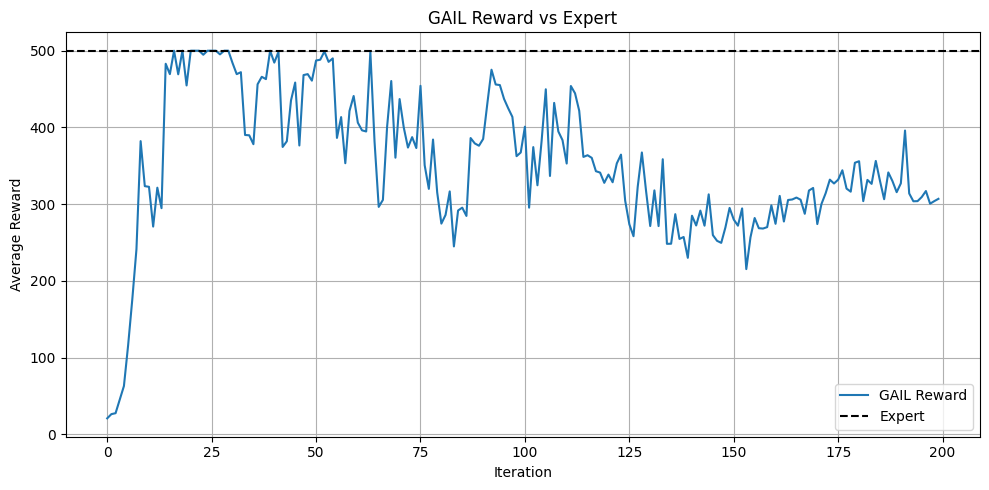

In [45]:
import pickle
import matplotlib.pyplot as plt

# Load results
with open("ckpts/CartPole-v1/results.pkl", "rb") as f:
    exp_rwd_mean, rwd_iter_means = pickle.load(f)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(rwd_iter_means, label="GAIL Reward", color="tab:blue")
plt.axhline(exp_rwd_mean, color="k", linestyle="--", label="Expert")

plt.xlabel("Iteration")
plt.ylabel("Average Reward")
plt.title("GAIL Reward vs Expert")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
